# Transfer Learning Part 2: Fine Tuning

In the previous notebook, we covered transfer learning feature extranction but now, we are going to learn about new kind of transfer learning: fine-tuning.


This time we are going to see how we can use the pretrained models within `tf.keras.applications` and apply them to on our problem. (food recognization)

In [ ]:
# Import necessary libraries
import os
import datetime
import random
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

print(tf.__version__)

2.12.0


## Get some data


In [ ]:
# Get %10 of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2023-07-09 14:25:03--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.125.128, 142.250.136.128, 142.250.148.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   221MB/s    in 0.7s    

2023-07-09 14:25:04 (221 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [ ]:
# Check out how many images and directories we have
for dir in os.walk('10_food_classes_10_percent'):
    print(f"There are {len(dir[1])} directories and {len(dir[2])} images in '{dir[0]}'")

There are 2 directories and 0 images in '10_food_classes_10_percent'
There are 10 directories and 0 images in '10_food_classes_10_percent/train'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_ric

In [ ]:
# Creating training and test directories path
train_dir = '/content/10_food_classes_10_percent/train/'
test_dir = '/content/10_food_classes_10_percent/test/'

In [ ]:
# Set global image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load train and test images into batches
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            label_mode='categorical',
                                                                            image_size=IMG_SIZE,
                                                                            batch_size=BATCH_SIZE)

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           label_mode='categorical',
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Check out the train batch datasets
train_data_10_percent

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In previous notebook, I generally prefered to use Sequential model but in this notebook, I will use functional API models. The sequential model is straight-forward, it runs our layer is sequential order. But the functional API gives us more flexibility with our models.

Sequential API Models:

* Sequential models are a linear stack of layers, where each layer is connected to the next in a sequential manner.
* They are suitable for simple, sequential modeling tasks with a single input and a single output.
* They are easy to use and have a straightforward structure, making them ideal for beginners or simple architectures.
* Sequential models do not support multiple inputs or outputs without workarounds.
* They are less flexible when it comes to complex model architectures or shared layers.

Functional API Models:

* Functional API models allow for more complex and flexible model architectures.
* They enable the creation of models with multiple inputs and outputs, making them suitable for tasks that require multiple data streams or multiple predictions.
* Functional models are not limited to a linear stack of layers and can contain branching or merging layers, allowing for more intricate architectures.
* They support shared layers, which means the same layer can be called multiple times with different inputs, allowing for weight sharing and reuse.
* Functional models can handle complex computations, including conditional branches and loops, making them more suitable for advanced use cases.
* They provide more control over the model structure and allow for the creation of models with shared layers, skip connections, or complex architectures.


Functional API: https://www.tensorflow.org/guide/keras/functional_api



Here is what we will be experimenting with:

* Model 0:
    * Data: Random **%10** training data only (Food101)
    * Preprocessing: None
    * Model: EfficientNetB0 **feature extractor** model with no top (all layers frozen)

* Model 1:
    * Data: Random **%1** training data only (Food101)
    * Preprocessing: Data augmentation
    * Model: EfficientNetB0 **feature extractor** model with no top (all layers frozen)

* Model 2:
    * Data: Random **%10** training data only (Food101)
    * Preprocessing: Data augmentation
    * Model: EfficientNetB0 **feature extractor** model with no top (all layers frozen)

* Model 3:
    * Data: Random **%10** training data only (Food101)
    * Preprocessing: Data augmentation
    * Model: EfficientNetB0 **fine tuning** model (top 10 layers unfrozen)

* Model 4:
    * Data: Random **%100** training data only (Food101)
    * Preprocessing: Data augmentation
    * Model: EfficientNetB0 **fine tuning** model (top 10 layers unfrozen)

## Model 0: Feature extraction transfer learning on %10 of the data without data augmentation

```
# This is formatted as code
```



Data: Random **%10** training data only (Food101)
<br>Preprocessing: No data augmentation
<br>Model: EfficientNetB0 **feature extractor** model with no top (all layers frozen)

In [ ]:
# Create a TensorBoard callbakc (functionized because we need to create a new one for each model)
def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f'Saving TensorBoard log files to: {log_dir}')
    return tensorboard_callback

In [ ]:
# 1. Create a base with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # this model output layer is 1000 but in our case we have 10 outputs
                                                                     # so include_top should be false

# 2. Freeze the base model (so the underlying pre-trained patters aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')

# 4. If using ResNet50V2 you will need to normalize inputs (EfficientNet has already rescaling built-in)
# x = tf.keras.layers.experimantal.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base model
x = base_model(inputs)
print(f'Shape after passing inputs  through base model: {x.shape}')

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computation)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print(f'Shape after GlobalAveragePooling2D: {x.shape}')

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# 8. Compine the inputs and outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

# 10. Fit the model and save its history
model_0_history = model_0.fit(train_data_10_percent,
                              epochs=5,
                              steps_per_epoch=len(train_data_10_percent),
                              validation_data=test_data_10_percent,
                              validation_steps=len(test_data_10_percent),
                              callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                     experiment_name='Model_0_10_percent_feature_extraction')])

Shape after passing inputs  through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/Model_0_10_percent_feature_extraction/20230709-142509
Epoch 1/5
24/24 [==============================] - 21s 597ms/step - loss: 1.8895 - accuracy: 0.4240 - val_loss: 1.3240 - val_accuracy: 0.7092
Epoch 2/5
24/24 [==============================] - 8s 309ms/step - loss: 1.1138 - accuracy: 0.7640 - val_loss: 0.8912 - val_accuracy: 0.8068
Epoch 3/5
24/24 [==============================] - 7s 303ms/step - loss: 0.7922 - accuracy: 0.8240 - val_loss: 0.7075 - val_accuracy: 0.8376
Epoch 4/5
24/24 [==============================] - 8s 341ms/step - loss: 0.6431 - accuracy: 0.8573 - val_loss: 0.6148 - val_accuracy: 0.8512
Epoch 5/5
24/24 [==============================] - 8s 343ms/step - loss: 0.5453 - accuracy: 0.8760 - val_loss: 0.5572 - val_accuracy: 0.8608


In [ ]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

In [ ]:
# How about the summary of the base model?
base_model.summary()

In [ ]:
# How about the summary of the model_0?
model_0.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


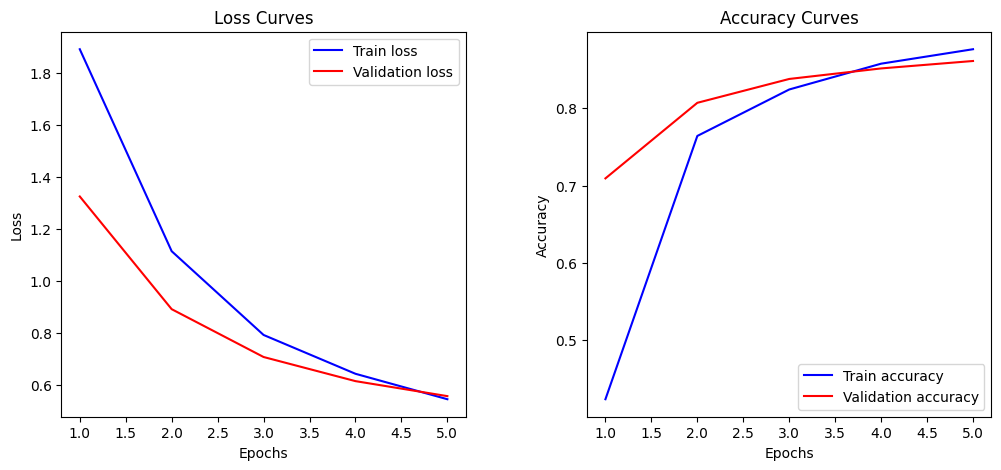

In [ ]:
# Check out the plot loss curves
def plot_loss_curves(history):

    '''
    Plot the loss and accuracy curves for training and validation parts.

    Args:
        history: TensorFlow history object.
    Returns:
        Loss and accuracy curves for training and validation
    '''

    # Convert history to dataframe
    dataframe = pd.DataFrame(history.history)
    dataframe = dataframe.set_index(pd.Index(range(1, len(dataframe) + 1)))

    # Set the plot size
    plt.figure(figsize=(12, 5))

    # Plot train and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(dataframe['loss'], 'b', label='Train loss')
    plt.plot(dataframe['val_loss'], 'r', label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()

    # Plot train and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(dataframe['accuracy'], 'b', label='Train accuracy')
    plt.plot(dataframe['val_accuracy'], 'r', label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves')
    plt.legend()

    # Adjust spaces and plot
    plt.subplots_adjust(wspace=0.3)
    plt.show()


plot_loss_curves(model_0_history)

## Getting a feature vector from a trained model


Let's demonstrate the Glabal Average Pooling 2D layer.

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

But then when it pass through GloabalAveragePooling2D, it turns into (None, 1280)

Let's use a similiar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [ ]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
input_tensor = tf.random.normal(input_shape)
print(f'Random input tensor: \n {input_tensor}\n')

# Pass the tensor through the global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f'2D Global Average Pooled tensor:\n{global_average_pooled_tensor}\n')
global_average_pooled_tensor

# Check the shape of tensors
print(f'Shape of the input tensor: {input_tensor.shape}')
print(f'Shape of the 2D Global Average Pooled tensor: {global_average_pooled_tensor.shape}')

Random input tensor: 
 [[[[-0.6533557   0.40211475  0.5395649 ]
   [ 0.5370337  -0.05598431  0.88128364]
   [-1.0843416  -1.495471    1.0504022 ]
   [ 1.6119045  -0.4493976   2.2351248 ]]

  [[ 1.2902019   1.3473117   2.7861016 ]
   [ 0.6271704   0.02175172 -1.1078968 ]
   [-1.3900374   0.01340732 -0.5374046 ]
   [-0.83153194  0.14971158 -2.0707877 ]]

  [[ 2.0409703  -1.210746   -0.5092656 ]
   [ 2.3112683  -0.32484186  1.2903236 ]
   [-0.8429005  -0.01772635  1.0446831 ]
   [ 1.3790557  -0.545141    0.34407672]]

  [[-0.16951016  0.82027704  0.12071215]
   [-0.20632432 -0.8287588  -0.5877895 ]
   [ 1.2151499   0.41093364  1.0103098 ]
   [ 2.5427299  -0.0444582  -0.7492328 ]]]]

2D Global Average Pooled tensor:
[[ 0.5235927  -0.11293859  0.35876286]]

Shape of the input tensor: (1, 4, 4, 3)
Shape of the 2D Global Average Pooled tensor: (1, 3)


In [ ]:
# Let's replicate the GlobalAveragePooling2D
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[ 0.5235927 , -0.11293859,  0.35876286]], dtype=float32)>

## Model 1: Feature extraction transfer learning on %1 of the data with data augmentation

The model will remain the same in this part (EfficientNetB0). However, we will use only 1% of data for training instead of 10% and compare the results with model_0 by using data augmentation techniques to increase the diversity of data.

* Data: Random %1 training data only (Food101)
* Preprocessing: Data augmentation
* Model: EfficientNetB0 feature extractor model with no top (all layers frozen)



In [ ]:
# Download and unzip the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

zip_ref = zipfile.ZipFile('10_food_classes_1_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2023-07-09 14:26:10--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.161.128, 142.251.172.128, 74.125.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.161.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   107MB/s    in 1.2s    

2023-07-09 14:26:12 (107 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# Create the train and test dir
train_dir = '10_food_classes_1_percent/train/'
test_dir = '10_food_classes_1_percent/test/'

In [ ]:
# How many images and directories we have?
for dir in os.walk('10_food_classes_1_percent'):
    print(f"There are {len(dir[1])} directories and {len(dir[2])} images in '{dir[0]}'")

There are 2 directories and 0 images in '10_food_classes_1_percent'
There are 10 directories and 0 images in '10_food_classes_1_percent/train'
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'
There are 10 direct

**Note that we only have 7 images for each classes for training.**

In [ ]:
# Set up data loaders
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                           label_mode='categorical',
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)

test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                          label_mode='categorical',
                                                                          image_size=IMG_SIZE,
                                                                          batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Adding data augmentation into our model
To add data augmentation right into our models, we can use the layers inside:
* `tf.keras.layers.experimental.preprocessing`

Link: https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing

Benefits of using data augmentation inside the morel are:
* Preprocessing of images happens on the GPU (much faster) rather than CPU
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere.

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc.
data_augmentation = tf.keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescale(1./255) # This is for ResNet50V2 but for EfficientNet we dont need that
], name='data_augmentation')

### Visualize the our data augmentation layer (and see what happens to our data)

In [ ]:
# Remind the class names
train_data_1_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

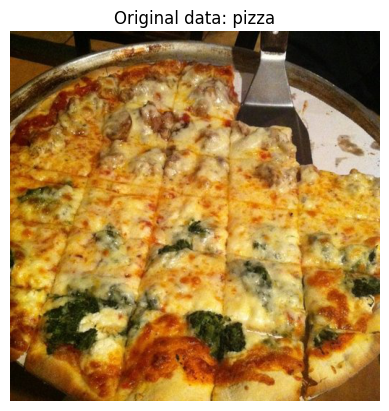

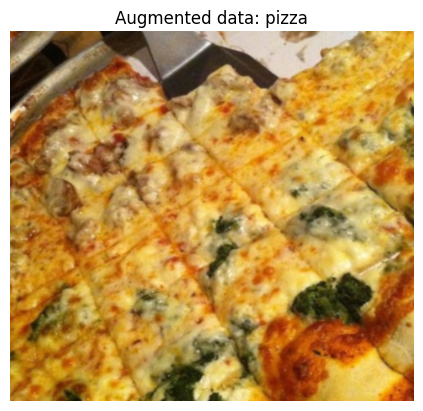

In [ ]:
# View a random image and compare it to its augmented version
target_classes = random.choice(train_data_1_percent.class_names)
target_dir = '10_food_classes_1_percent/train/' + target_classes
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + '/' + random_image

# Read in the random image and plot it
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f'Original data: {target_classes}')
plt.axis(False)
plt.show()

# Plot the augmented random image
augmented_img = data_augmentation(img, training=True)
plt.imshow(augmented_img/255.)
plt.title(f'Augmented data: {target_classes}')
plt.axis(False)
plt.show()

### Model 1: Feature extraction transfer learning on %1 of the data with data augmentation

In [ ]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the input layer
inputs = tf.keras.layers.Input(shape=input_shape, name='input_layer')

# Add data augmentation in model as a layer
x = data_augmentation(inputs)

# Give base_model the input (after data augmentation) and dont train it
x = base_model(x, training=False)

# Pool outpt featre of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

# Put a dense layer as the output layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# Make a model using the inputs and outputs
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

# Fit the model
model_1_history = model_1.fit(train_data_1_percent,
                              epochs=5,
                              steps_per_epoch=len(train_data_1_percent),
                              validation_data=test_data_1_percent,
                              validation_steps=len(test_data_1_percent),
                              callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                     experiment_name='Model_1_1_percent')])

Saving TensorBoard log files to: transfer_learning/Model_1_1_percent/20230709-142617
Epoch 1/5
3/3 [==============================] - 16s 4s/step - loss: 2.4163 - accuracy: 0.0571 - val_loss: 2.2641 - val_accuracy: 0.1508
Epoch 2/5
3/3 [==============================] - 7s 3s/step - loss: 2.1198 - accuracy: 0.2143 - val_loss: 2.1253 - val_accuracy: 0.2464
Epoch 3/5
3/3 [==============================] - 8s 4s/step - loss: 1.9560 - accuracy: 0.4143 - val_loss: 2.0082 - val_accuracy: 0.3316
Epoch 4/5
3/3 [==============================] - 7s 3s/step - loss: 1.7752 - accuracy: 0.5286 - val_loss: 1.9025 - val_accuracy: 0.3992
Epoch 5/5
3/3 [==============================] - 12s 5s/step - loss: 1.5499 - accuracy: 0.7429 - val_loss: 1.8079 - val_accuracy: 0.4556


In [ ]:
# Check the model summary
model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

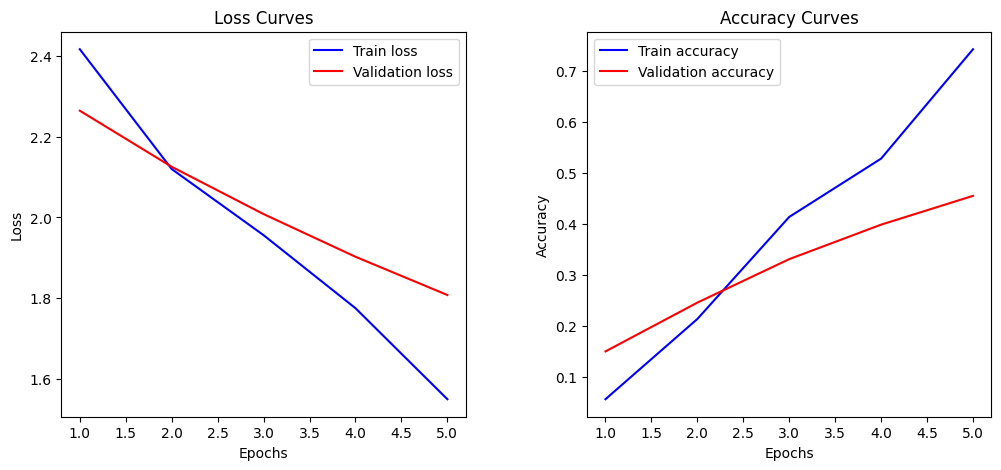

In [ ]:
plot_loss_curves(model_1_history)

Our accuracy is lower than with the previous model, but only 1% of the data (7 images for per class) was used for training. As a result, this accuracy score is not too bad and indicates the power of data augmentation techniques. We didn't use any data augmentation techniques in the previous model (model_0) since we had 10% of training data instead of 1%. What happens when we use data augmentation techniques with 10% training data? Want to know? Let's code.

## Model 2: Feature extraction transfer learning on %10 of the data with data augmentation

This model will be same as Model 0 but we will use data augmentation techniques this time.

* Data: Random %10 training data only (Food101)
* Preprocessing: Data augmentation
* Model: EfficientNetB0 feature extractor model with no top (all layers frozen)

In [ ]:
# Create the train and test paths
train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

In [ ]:
# Setup data loaders
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            label_mode='categorical',
                                                                            image_size=IMG_SIZE,
                                                                            batch_size=BATCH_SIZE)

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           label_mode='categorical',
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Create data augmentation
data_augmentation = tf.keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomRotation(0.2)
], name='data_augmentation')

In [ ]:
# Setup input shape and base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the input layer
inputs = tf.keras.layers.Input(shape=input_shape, name='input_layer')

# Add data augmentation in model as a layer
x = data_augmentation(inputs)

# Give base_model the input (after data augmentation) and dont train it
x = base_model(x, training=False)

# Pool output feature of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

# Output layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# Make the model using input and output layers
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model
model_2.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

### Create a ModelCheckpoint callback
The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can come and start where we left off.

In [ ]:
# Set check point path
checkpoint_path = 'ten_percent_model_checkpoints_weights/checkpoint.ckpt'

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq='epoch',
                                                         verbose=1)

### Fit model 2 passing in the ModelCheckpoint callback

In [ ]:
# Fit the model
model_2_history = model_2.fit(train_data_10_percent,
                              epochs=5,
                              validation_data=test_data_10_percent,
                              validation_steps=len(test_data_10_percent),
                              callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                     experiment_name='Model_2_10_percent'), checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/Model_2_10_percent/20230709-142314


Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9789 - accuracy: 0.3493
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 38s 981ms/step - loss: 1.9789 - accuracy: 0.3493 - val_loss: 1.4359 - val_accuracy: 0.6756
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2983 - accuracy: 0.7000
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 19s 785ms/step - loss: 1.2983 - accuracy: 0.7000 - val_loss: 0.9930 - val_accuracy: 0.7840
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0145 - accuracy: 0.7640
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 16s 671ms/step - loss: 1.0145 - accuracy: 0.7640 - val_loss: 0.7961 - val_accuracy: 0.8112
Epoch 4/5
24/24 [==============================] - ETA: 0s - loss: 0.8527 - accuracy: 0.

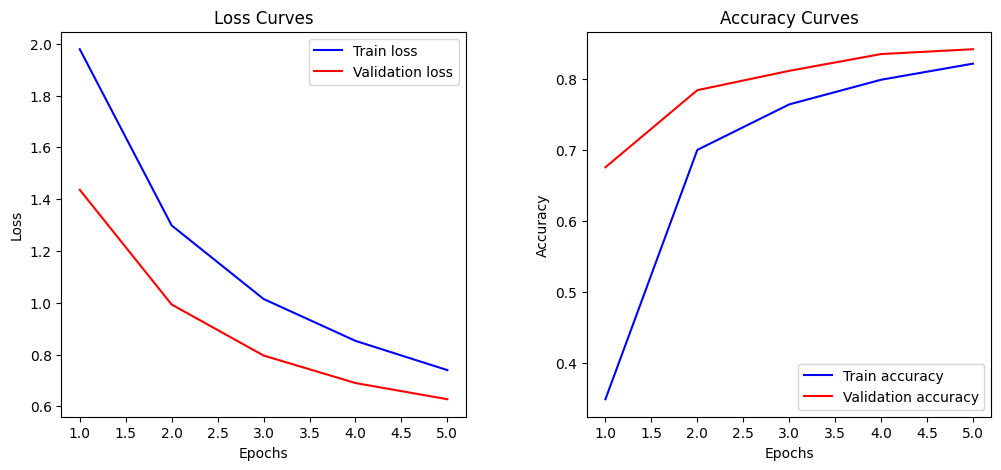

In [ ]:
# Plot the loss curves for model_2
plot_loss_curves(model_2_history)

In [ ]:
# Compare the results with model_0
print(f'Model_0 test data accuracy: {model_0.evaluate(test_data_10_percent)}')
print(f'Model_2 test data accuracy: {model_2.evaluate(test_data_10_percent)}')

79/79 [==============================] - 7s 79ms/step - loss: 0.5572 - accuracy: 0.8608
Model_0 test data accuracy: [0.5572192072868347, 0.86080002784729]
79/79 [==============================] - 9s 78ms/step - loss: 2.3827 - accuracy: 0.0964
Model_2 test data accuracy: [2.382672071456909, 0.09640000015497208]


As you see above, results are so close furthermore model_2 gives us a little lower accuracy rather than model_0. That means our data augmentation techniques didn't effect as well as we expect.

### Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint.


In [ ]:
# Load in saved model weights and evaluate the model
model_2.load_weights(checkpoint_path)

If the results from our previously evaluated model_2 match the loaded weights, everything has worked.

In [ ]:
# Evaluate model_2 with loaded weights
loaded_weighted_model_results = model_2.evaluate(test_data_10_percent)

79/79 [==============================] - 6s 70ms/step - loss: 0.6274 - accuracy: 0.8416


Yes, we get same results.

## Model 3: Fine tuning an existing model on %10 of the data with data augmentation

Fine-tuning usually works best after training a feature extraction model for a few epochs with large amounts of custom data.

This model will be our first fine tuning model and here are the properties of the model:

* Data: Random %10 training data only (Food101)
* Preprocessing: Data augmentation
* Model: EfficientNetB0 fine tuning model with top layer trained on custom data, top 10 layers unfrozen



In [ ]:
# Check the layers in model_2
model_2.layers

In [ ]:
# Are these layers trainable?
for layer in model_2.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f6cad206620> True
<keras.engine.sequential.Sequential object at 0x7f6cad299690> True
<keras.engine.functional.Functional object at 0x7f6cacf926e0> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7f6cad20ece0> True
<keras.layers.core.dense.Dense object at 0x7f6cacfecc40> True


In [ ]:
# What layers are in our base_model and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
    print(i, layer.name, layer.trainable)

In [ ]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [ ]:
# To begin fine-tuning lets start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
    layer.trainable = False

In [ ]:
# Recompile  (we have to recompile our models every time we make a change)
model_2.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # when fine-tuning, typically you should set the learning rate lower
    metrics=['accuracy']
)

In [ ]:
# Let's check the how many layers trainable in model_2
for num, layer in enumerate(model_2.layers[2].layers):
    print(num, layer.name, layer.trainable)

Now, our last 10 layer is trainable.

In [ ]:
# Check out how many trainable variables we have on model_2
len(model_2.trainable_variables)

12

In [ ]:
# Fine tune for another 5 epochs
fine_tune_epochs = 10

# Refit the model (same as model 2 except more trainable layers)
model_3_history = model_2.fit(train_data_10_percent,
                              epochs=fine_tune_epochs,
                              validation_data=test_data_10_percent,
                              validation_steps=len(test_data_10_percent),
                              initial_epoch=model_2_history.epoch[-1], # start training previous last epoch
                              callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                     experiment_name='model_3_10_percent')])

Saving TensorBoard log files to: transfer_learning/model_3_10_percent/20230709-142748
Epoch 5/10
24/24 [==============================] - 28s 708ms/step - loss: 0.6455 - accuracy: 0.8293 - val_loss: 0.5013 - val_accuracy: 0.8472
Epoch 6/10
24/24 [==============================] - 15s 615ms/step - loss: 0.4930 - accuracy: 0.8587 - val_loss: 0.4484 - val_accuracy: 0.8620
Epoch 7/10
24/24 [==============================] - 14s 573ms/step - loss: 0.4334 - accuracy: 0.8813 - val_loss: 0.4439 - val_accuracy: 0.8572
Epoch 8/10
24/24 [==============================] - 14s 583ms/step - loss: 0.4098 - accuracy: 0.8787 - val_loss: 0.4233 - val_accuracy: 0.8640
Epoch 9/10
24/24 [==============================] - 13s 548ms/step - loss: 0.3569 - accuracy: 0.9040 - val_loss: 0.4248 - val_accuracy: 0.8608
Epoch 10/10
24/24 [==============================] - 13s 520ms/step - loss: 0.3080 - accuracy: 0.9067 - val_loss: 0.4250 - val_accuracy: 0.8600


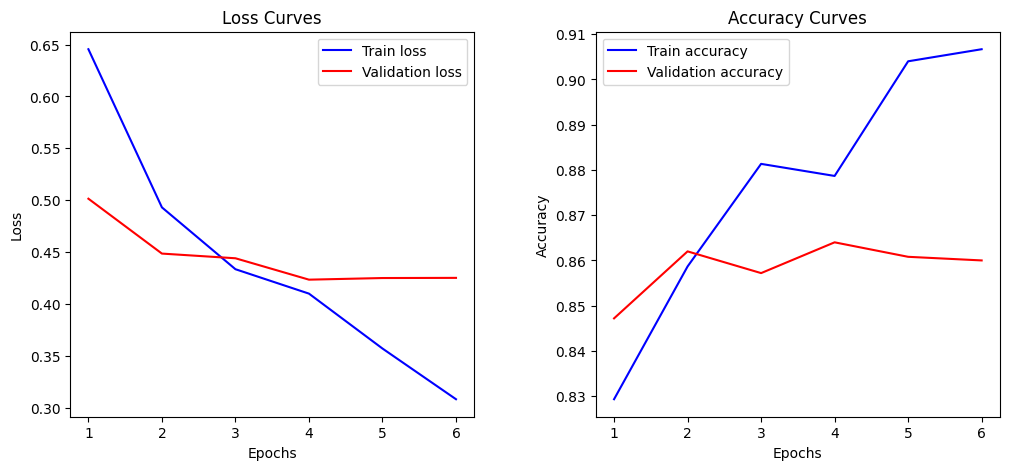

In [ ]:
# Let's plot the loss curves for fine-tuned model
plot_loss_curves(model_3_history)

In [ ]:
# Let's create a function to compare training histories
def compare_histories(original_history, new_history, initial_epoch=5):
    '''
    Compares two Tensorflow history objects
    '''
    # Get original history measurements
    acc = original_history.history['accuracy']
    loss = original_history.history['loss']

    val_acc = original_history.history['val_accuracy']
    val_loss = original_history.history['val_loss']

    # Combine original history with new history metrics
    total_acc = acc + new_history.history['accuracy']
    total_loss = loss + new_history.history['loss']

    val_total_acc = val_acc + new_history.history['val_accuracy']
    val_total_loss = val_loss + new_history.history['val_loss']

    # Make plots for accuracy and loss
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training accuracy')
    plt.plot(val_total_acc, label='Validation accuracy')
    plt.plot([initial_epoch-1, initial_epoch-1], plt.ylim(), label='Start Fine Tuning')
    plt.title('Accuracy curves')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training loss')
    plt.plot(val_total_loss, label='Validation loss')
    plt.plot([initial_epoch-1, initial_epoch-1], plt.ylim(), label='Start Fine Tuning')
    plt.title('Loss curves')
    plt.legend()
    plt.show()

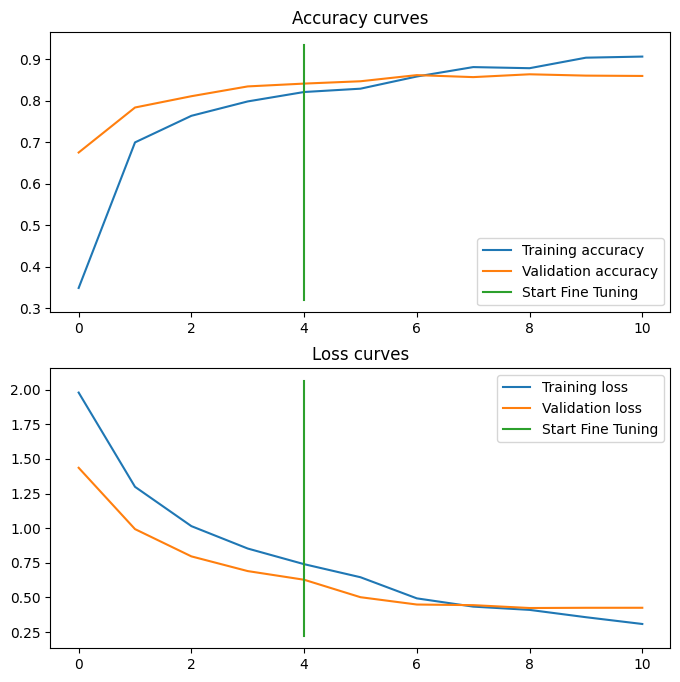

In [ ]:
compare_histories(model_2_history, model_3_history)

## Model 4: Fine tuning an existing model on the all data (%100) with data augmentation

* Data: Random %100 training data only (Food101)
* Preprocessing: Data augmentation
* Model: EfficientNetB0 fine tuning model with top layer trained on custom data, top 10 layers unfrozen

All we done is before:

1. Trained a feature extraction model for 5 epochs on %10 of the data with data augmentation (model_2) and saved the model's weights using 'ModelCheckpoint' callback.
2. Fine tuned the same model on the same %10 of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (model_3)
3. Saved the results and training logs each time.
4. Reloaded the model from step 1 to do the same steps as step 2 except this time we're going to use all of the data. (model_4)

In [ ]:
# Download and unizp the 10 classes of food all data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

# Unzip data
zip_ref = zipfile.ZipFile('10_food_classes_all_data.zip')
zip_ref.extractall()
zip_ref.close()

--2023-07-09 14:29:27--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.120.128, 142.251.171.128, 142.250.159.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.120.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.1’

10_food_classes_all 100%[===================>] 495.13M  78.4MB/s    in 4.4s    

2023-07-09 14:29:31 (111 MB/s) - ‘10_food_classes_all_data.zip.1’ saved [519183241/519183241]



In [ ]:
# Create the train and test dir
train_dir = '10_food_classes_all_data/train/'
test_dir = '10_food_classes_all_data/test/'

In [ ]:
# Check out how many images and directories we have
for dir in os.walk('10_food_classes_all_data'):
    print(f"There are {len(dir[1])} directories and {len(dir[2])} images in '{dir[0]}'")

There are 2 directories and 0 images in '10_food_classes_all_data'
There are 10 directories and 0 images in '10_food_classes_all_data/train'
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'
There are 1

In [ ]:
# Set global image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load train and test images into batches
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Check the which layers are tuneable in the whole model
for layer_number, layer in enumerate(model_2.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


In [ ]:
# Let's check out the which layers are trainable in the base_model (EfficientNetB0)
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

In [ ]:
# Recompile the model
model_2.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # Should be 10x lower
    metrics=['accuracy']
)

In [ ]:
# Fit the model
model_4_history = model_2.fit(train_data,
                              epochs=10,
                              validation_data=test_data,
                              validation_steps=int(len(test_data) * 0.25), # validate with %25 of the test data not all
                              initial_epoch=model_2_history.epoch[-1],
                              callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                     experiment_name='model_4_all_data')])

Saving TensorBoard log files to: transfer_learning/model_4_all_data/20230709-144501
Epoch 5/10
235/235 [==============================] - 78s 294ms/step - loss: 0.5960 - accuracy: 0.8085 - val_loss: 0.3842 - val_accuracy: 0.8799
Epoch 6/10
235/235 [==============================] - 57s 242ms/step - loss: 0.5066 - accuracy: 0.8369 - val_loss: 0.3184 - val_accuracy: 0.8947
Epoch 7/10
235/235 [==============================] - 56s 235ms/step - loss: 0.4481 - accuracy: 0.8575 - val_loss: 0.2774 - val_accuracy: 0.9211
Epoch 8/10
235/235 [==============================] - 51s 215ms/step - loss: 0.4107 - accuracy: 0.8679 - val_loss: 0.2830 - val_accuracy: 0.9030
Epoch 9/10
235/235 [==============================] - 43s 181ms/step - loss: 0.3801 - accuracy: 0.8755 - val_loss: 0.2633 - val_accuracy: 0.9095
Epoch 10/10
235/235 [==============================] - 44s 186ms/step - loss: 0.3507 - accuracy: 0.8859 - val_loss: 0.2703 - val_accuracy: 0.9128


In [ ]:
# Let's evaluate the model_4 with the all test data
model_2.evaluate(test_data)

79/79 [==============================] - 7s 78ms/step - loss: 0.2906 - accuracy: 0.9040


[0.29059281945228577, 0.9039999842643738]

Wowww. That's really cool. Finally we get very good accuracy score. Now, let's compare the plot the curves.

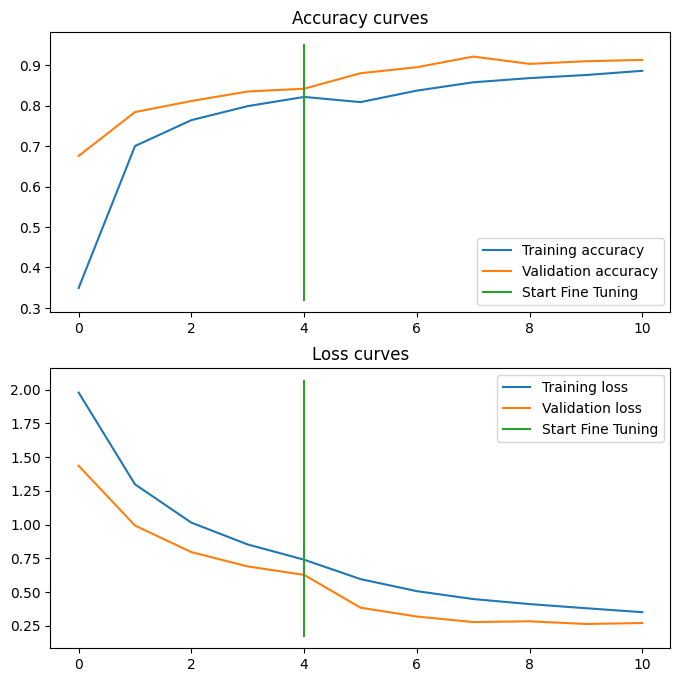

In [ ]:
# Compare the plot curves
compare_histories(model_2_history, model_4_history)

## Viewing our experiment data on TensorBoard

In [ ]:
# View tensorboard logs of transfer learning modelling experiments
# Upload TensorBoard dev recors
!tensorboard dev upload --logdir ./transfer_learning/ \
--name 'Transfer Learning Experiment with 10 Food101 Classes' \
--description 'A series of different transfer learning experiments with varying amoung of data' \
--one_shot # exits the uploader once its finished uploading

Here is the all model experiments link: https://tensorboard.dev/experiment/Yyz7ksMDSmWjzAj9YK45Ug/